In [ ]:
from bioservices import UniProt
import pickle
import pandas as pd
import cobra
from collections import defaultdict, OrderedDict, Counter
from cobra import Reaction, Metabolite, Model, Gene
import time
from glob import glob

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches
from Bio import SeqIO
import re
import os
import scipy
import urllib
from PseudoFind.lof_detection import *

import sys
sys.path.append("/home/yara/Documents/PseudoFind")
from PseudoFind.functional_annotations import *
from PseudoFind.pangenome_cmds import *
%matplotlib inline

In [ ]:
# getting matches from uniprot

# query acc.ver, subject acc.ver, % identity, alignment length, mismatches, gap opens, q. start, q. end, s. start, s. end, evalue, bit score, % positives
directory = '/home/yara/Documents/cystic_fibrosis/data/staphylococcus/'
BR = pd.read_csv('%s/functional_annotation/blast_uniprot_res.csv'%directory,
           names = ['Allele ID', 'Uniprot ID', 'PID','aln_length', 'mismatchCount', 'gapOpenCount', 'queryStart', 'queryEnd', 'subjectStart', 'subjectEnd', 'eVal', 'bit score', '% positives'])
BR = BR.loc[(BR['eVal'] < 10**(-9)) & (BR['PID'] >80)]
BR = BR.sort_values(by = 'PID', ascending = False).drop_duplicates(subset = 'Allele ID', keep = 'first')

# json_file = '%s/blast_uniprot_res.json'%directory
# BR = get_AAseqs_from_BR_json(json_file, BR)
    
for index in BR.index:
    
    uniprot_id = BR.loc[index, 'Uniprot ID'].split('.')[0]
    u = UniProt()
    res = u.retrieve( uniprot_id, frmt="xml")
    BR.loc[index, 'gene name'] = re.findall('(?<=\>).+?(?=\<\/name)', res.data)[1]
    BR.loc[index, 'patric'] = ', '.join(re.findall('(?<=")fig\|.+?(?=")', res.data))
    BR.loc[index, 'annotation'] = ','.join(re.findall('(?<=description\=").+?(?=")', res.data))
    BR.loc[index, 'KEGG'] = ','.join(re.findall('(?<=type\="KEGG"\ id\=").+?(?=")', res.data))
   
BR = BR.fillna('')
BR['KEGG_f'] = [x.split(':')[1].split(',')[0] if x != '' else '' for x in BR['KEGG'] ]

FT = pd.DataFrame()
for gb in glob('%s/functional_annotation/*.gb'%directory):
    FT = FT.append(get_FT_from_gb(gb))
cols = ['Nucleotide_sequence','old_locus_tag', 'old_locus_tag_1', 'locus_tag']
BR1 = BR.merge(FT[cols], left_on = 'KEGG_f', right_on = 'old_locus_tag', how = 'inner')
BR2 = BR.merge(FT[cols], left_on = 'KEGG_f', right_on = 'old_locus_tag_1', how = 'inner')
BR3 = BR.merge(FT[cols], left_on = 'KEGG_f', right_on = 'locus_tag', how = 'inner')
BR_all = BR1.append(BR2).append(BR3)


annotated = BR_all[['Allele ID', 'KEGG_f', 'Nucleotide_sequence', 'gene name', 'annotation']].rename(columns = {'KEGG_f':'Ref locus_tag'})
annotated['reference'] = ['blastp_uniprot']*len(annotated)

/home/yara/.local/lib/python3.5/site-packages/pandas/core/frame.py:6211 FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [ ]:
annotated

,Allele ID,Ref locus_tag,Nucleotide_sequence,gene name,annotation,reference
0,Allele_780,SAV1497,ATGGAAACAATTATTGAAGAATATTTGCGTTTTATACAAATTGAAA...,xerD,"Tyrosine recombinase XerD,Core-binding (CB),Ty...",blastp_uniprot
1,Allele_74190,SAV1276,ATGGTGTTGGGTGTTTTCCAATTAGGAATAATCGGTCGTCTAATTG...,ftsK,"DNA translocase FtsK,Helical,Helical,Helical,H...",blastp_uniprot
2,Allele_73124,SAUSA300_1291,ATGAATGAATTAGAATTTGTTACGAAACATCGCCGTCATTTACATC...,SAUSA300_1291,Uncharacterized hydrolase SAUSA300_1291,blastp_uniprot
3,Allele_58753,SaurJH9_1209,ATGAATAAACCAATAGGTGTAATAGACTCTGGTGTCGGAGGTTTGA...,murI,"Glutamate racemase,Substrate binding,Substrate...",blastp_uniprot
4,Allele_45236,SaurJH9_1257,ATGTCTGAACGTATTATAATGGATGATGCCGCAATACAACGTACAG...,pyrR,"Bifunctional protein PyrR,PRPP-binding",blastp_uniprot
5,Allele_76713,SAUSA300_1685,ATGGATTGGATTTTACCAATTGCTGGAATTATCGCTGCGATTGCAT...,SAUSA300_1685,"UPF0478 protein SAUSA300_1685,Helical",blastp_uniprot
6,Allele_42258,SaurJH9_1927,GTGCCGAAGATTACTAAAATAGAAGTTCAAAAGAAAAACAAAGAAC...,recX,Regulatory protein RecX,blastp_uniprot
7,Allele_4709,SaurJH9_1297,ATGGCAGTTAAAATTCGTTTAACACGTTTAGGTTCAAAAAGAAATC...,rpsP,30S ribosomal protein S16,blastp_uniprot
8,Allele_65512,MW0234,ATGATGAAATTTTCAGTAATAGTTCCAACATACAATTCAGAAAAGT...,tarS,Poly(ribitol-phosphate) beta-N-acetylglucosami...,blastp_uniprot
0,Allele_85977,SACOL0533,ATGGCTAAAGAAACATTTTATATAACAACCCCAATATACTATCCTA...,metG,"Methionine--tRNA ligase,tRNA-binding,'HIGH' re...",blastp_uniprot


In [ ]:
# getting matches from GEM

selected_features_final = pd.read_csv('%s/functional_annotation/selected_features_final_m.csv'%directory, index_col = ['Unnamed: 0']).fillna('')
seif = selected_features_final.loc[selected_features_final['locus_tag_y'] != ''].rename(columns = {'Reaction(s)':'annotation', 'gene':'gene name', 'locus_tag_y':'Ref locus_tag'})
seif = seif.merge(FT[['Nucleotide_sequence', 'locus_tag']], left_on = 'Ref locus_tag', right_on = ['locus_tag'])
seif['reference'] = ['seif']*len(seif)
annotated = annotated.append( seif[annotated.columns])

In [ ]:
# cleaning up

annotated = annotated.drop_duplicates(subset = ['Allele ID'])
annotated = annotated.drop(annotated.loc[annotated['Nucleotide_sequence'] == ''].index)
annotated = annotated.reset_index()
del annotated['index']

In [ ]:
# getting nucleotide sequences

SoI_FT = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/staphylococcus/FT_LRI.csv', dtype = {'Genome ID':str}).set_index('Genome ID')
del SoI_FT['Unnamed: 0']

features = '%s/machine_learning/selected_features_final.fa'%directory
with open(features, 'r') as f:
    string = f.read()
feature_seqs = {x.split('\n')[0].replace('>',''):''.join(x.split('\n')[1:]) for x in string.split('\n>')}

rows = []
locus2allele = pickle.load(open('%s/allele_matrix/locus2allele.p'%directory, 'rb'))
locus2allele_rev = {y:x for x,y in locus2allele.items()}

for allele_id, aa_seq in feature_seqs.items():
    locus_tag = locus2allele_rev[allele_id]
    gid = '_'.join(locus_tag.split('_')[:-1])
    ffn_file = SoI_FT.loc[gid, 'Directory'].replace('.faa','.ffn').replace('_m','')
    with open(ffn_file, 'r') as f:
        string = f.read()
    gene_seqs = {x.split('\n')[0].replace('>','').split(' ')[0]:''.join(x.split('\n')[1:]) for x in string.split('\n>')}  
    rows.append({'Allele ID':allele_id, 'Protein sequence':aa_seq, 'Nucleotide sequence': gene_seqs[locus_tag]})
    
selected_features = pd.DataFrame(rows)
annotated = annotated.merge(selected_features.rename(columns = {'Nucleotide sequence':'Nucleotide sequence (allele)', 'Protein sequence':'Protein sequence (allele)'}), on = 'Allele ID', how = 'inner')

annotated = annotated.merge(selected_features_final[['Allele ID', 'score_x']], on = 'Allele ID', how = 'left')

In [ ]:
output_directory = '/home/yara/Documents/cystic_fibrosis/data/pseudomonas/allele_matrix/'

locus2allele = pickle.load(open('%s/locus2allele.p'%output_directory, 'rb'))
locus2allele_rev = {y:x for x,y in locus2allele.items()}


for index in annotated.index:
    
    print(index)
    allele_id = annotated.loc[index, 'Allele ID']  
    ref_seq = annotated.loc[index, 'Ref locus_tag']
    sequences = {ref_seq: annotated.loc[index, 'Nucleotide_sequence'], allele_id: annotated.loc[index, 'Nucleotide sequence (allele)']}
    point_mutations, deletions, insertions = get_alignment_summary(ref_seq, allele_id, sequences)

    annotated.loc[index, 'SNP -n'] = ' AND '.join(point_mutations)
    annotated.loc[index, 'deletions -n'] = ' AND '.join(['%s%s'%(x,y) for x,y in deletions.items()])
    annotated.loc[index, 'insertions -n'] = ' AND '.join(['%s%s'%(x,y) for x,y in insertions.items()])
    annotated.loc[index, 'major deletions -n'] = ' AND '.join(['%s%s'%(x,y) for x,y in deletions.items() if len(y) > 30])
    annotated.loc[index, 'major insertions -n'] = ' AND '.join(['%s%s'%(x,y) for x,y in insertions.items() if len(y) > 30])
    annotated.loc[index, 'start -n'] = '' if sequences[ref_seq][:3] == sequences[allele_id][:3] else '%s->%s'%(sequences[ref_seq][:3], sequences[allele_id][:3])


    sequences = {ref_seq: Seq(annotated.loc[index, 'Nucleotide_sequence']).translate(), allele_id: Seq(annotated.loc[index, 'Nucleotide sequence (allele)']).translate()}

    point_mutations, deletions, insertions = get_alignment_summary(ref_seq, allele_id, sequences)
    annotated.loc[index, 'SNP -p'] = ' AND '.join(point_mutations)
    annotated.loc[index, 'deletions -p'] = ' AND '.join(['%s%s'%(x,y) for x,y in deletions.items()])
    annotated.loc[index, 'insertions -p'] = ' AND '.join(['%s%s'%(x,y) for x,y in insertions.items()])
    annotated.loc[index, 'major deletions -p'] = ' AND '.join(['%s%s'%(x,y) for x,y in deletions.items() if len(y) > 10])
    annotated.loc[index, 'major insertions -p'] = ' AND '.join(['%s%s'%(x,y) for x,y in insertions.items() if len(y) > 10])
    annotated.loc[index, 'stops'] = ' AND '.join({str(x.start()) for x in re.finditer('\*', str(sequences[allele_id][:-1]))})
    annotated.loc[index, 'start -p'] = '' if sequences[ref_seq][0] == sequences[allele_id][0] else '%s->%s'%(sequences[ref_seq][0], sequences[allele_id][0])    
    
annotated.to_csv('/home/yara/Documents/cystic_fibrosis/data/staphylococcus/functional_annotation/alignments_v1.csv')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


In [ ]:
# map the 52 genes to the pan genome matrix
with open('%s/functional_annotation/selected_features_final.ffn'%directory, 'w') as y:
    for index in selected_features.index:
        y.write('>'+selected_features.loc[index, 'Allele ID']+'\n'+ selected_features.loc[index, 'Nucleotide sequence']+'\n')
        
reference = '%s/functional_annotation/TCH1516.ffn'%directory
with open(reference, 'r') as f:
    string = f.read()
gene_seqs = {re.findall('USA300HOU_RS[0-9]+', x)[0]:''.join(x.split('\n')[1:]) for x in string.split('\n>')}

reference = reference.replace('.ffn','_m.ffn')
with open(reference, 'w') as y:
    for gene, seq in gene_seqs.items():
        y.write('>'+gene+'\n'+seq+'\n')

features = '%s/functional_annotation/selected_features_final.ffn'%directory

blast_directory = '%s/pangenome/BR_results'%directory

makeblastdb = 'makeblastdb -in %s -parse_seqids -dbtype nucl'%features
print(os.system(makeblastdb))

makeblastdb = 'makeblastdb -in %s -parse_seqids -dbtype nucl'%reference
print(os.system(makeblastdb))

BR1_out = '%s/BR1/%s'%(blast_directory, 'TCH1516')
blastp = 'blastn -query %s -db %s -outfmt 6 -out %s'%(reference, features, BR1_out)
print(os.system(blastp))

BR2_out =  '%s/BR2/%s'%(blast_directory, 'TCH1516')
blastp = 'blastn -query %s -db %s -outfmt 6 -out %s'%(features, reference, BR2_out)
print(os.system(blastp))

PID_threshold = 50
output_file_name = 'TCH1516'
read_blast_results(blast_directory, PID_threshold, output_file_name)
bbh = pickle.load(open('%s/%s.p'%(blast_directory,output_file_name),'rb'))
set(bbh['TCH1516'].keys()) - set(selected_features['Allele ID'])

0
0
0
0


set()

In [ ]:
bootstrap_rows = pickle.load(open('/home/yara/Documents/cystic_fibrosis/data/staphylococcus/machine_learning/bootstrap_rows_SVC_trial_2.p', 'rb'))
bootstrap_res = pd.DataFrame(bootstrap_rows).fillna(0)
sorted_features = abs(bootstrap_res).sum(axis = 1).sort_values(ascending = False)

cdhit_clusters = get_cdhit_clusters('/home/yara/Documents/cystic_fibrosis/data/staphylococcus/pangenome/staphylococcus_pangenome_cdhit.clstr')
cdhit_clusters_rev = {y:x for x,z in cdhit_clusters.items() for y in z}
output_directory = '/home/yara/Documents/cystic_fibrosis/data/staphylococcus/allele_matrix/'
allele2cdhit = pickle.load(open('%s/allele2cdhit.p'%output_directory, 'rb'))
allele2cdhit_rev = defaultdict(list)
for allele, cdhit in allele2cdhit.items():
    allele2cdhit_rev[cdhit].append(allele)
    
allele2variant_count = {int(allele.split('_')[-1]): len(allele2cdhit_rev[cdhit]) for allele, cdhit in allele2cdhit.items()}

In [ ]:
import matplotlib.patches as mpatches
import matplotlib

In [ ]:
[int(selected_features_final.loc[index, 'Allele ID'].split('_')[-1]) for index in selected_features_final.index if selected_features_final.loc[index, 'score_x'] < 0]

25

In [ ]:
selected_features_final.set_index('Allele ID').loc[set(selected_features_final['Allele ID']) - set(annotated['Allele ID'])].iloc[2].to_dict()

{'Allele sequence': 'MNNEVPETLKDKRVMSLDMGTVVAGTKYRGEFEERLKKVMEEIQQAGNVILFIDELHTLVGAGGAEGAIDASNILKPALARGELQCIGATTLDEYRKNIEKDAALERRFQPVQVDEPSVVDTVAILKGLRDRYEAHHRINISDEAIEAAVKLSNRYVSDRFLPDKAIDLIDEASSKVRLKSHTTPNNLKEIEQEIEKVKNEKDAAVHAQEFENAANLRDKQTKLEKQYEEAKNEWKNAQNGMSTSLSEEDIAEVIAGWTGIPLTKINETESEKLLSLEDTLHERVIGQKDAVNSISKAVRRARAGLKDPKRPIGSFIFLGPTGVGKTELARALAESMFGDDDAMIRVDMSEFMEKHAVSRLVGAPPGYVGHDDGGQLTEKVRRKPYSVILFDEIEKAHPDVFNILLQVLDDGHLTDTKGRTVDFRNTIIIMTSNVGAQELQDQRFAGFGGSSDGQDYETIRKTMLKELKNSFRPEFLNRVDDIIVFHKLTKEELKEIVTMMVNKLTNRLSEQNINIIVTDKAKDKIAEEGYDPEYGARPLIRAIQKTIEDNLSELILDGNQIEGKKVTVDHDGKEFKYDIAEQTSETKTPSQA',
 'CD-hit ID': 'Cluster 156',
 'COG (grouped)': 'Cellular Processes & Signaling',
 'COG cat': 'O',
 'Cog cat description': 'molecular chaperones and related functions',
 'EC_number': '',
 'GO': 'GO:0000166,GO:0001882,GO:0001883,GO:0003674,GO:0003824,GO:0005488,GO:0005515,GO:0005524,GO:0005575,GO:0005618,GO:0005622,GO:0005623,GO:0005737,GO:0005829,GO:0005886,GO:0006139,GO:0006152,GO

Text(0.5, 1.0, 'S. aureus')

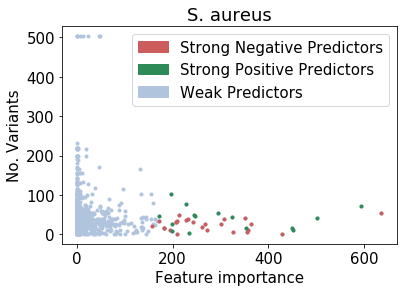

In [ ]:
matplotlib.rcParams.update({'font.size': 15, 'font.weight':'normal'})
plt.plot(list(sorted_features), [allele2variant_count[x] for x in sorted_features.index], '.', color = 'lightsteelblue')

selected_variants_minus = [int(selected_features_final.loc[index, 'Allele ID'].split('_')[-1]) for index in selected_features_final.index if selected_features_final.loc[index, 'score_x'] < 0]
plt.plot(sorted_features.loc[selected_variants_minus], [allele2variant_count[x] for x in selected_variants_minus], '.', color = 'indianred')

selected_variants_plus = [int(selected_features_final.loc[index, 'Allele ID'].split('_')[-1]) for index in selected_features_final.index if selected_features_final.loc[index, 'score_x'] > 0]
plt.plot(sorted_features.loc[selected_variants_plus], [allele2variant_count[x] for x in selected_variants_plus], '.', color = 'seagreen')


plt.ylabel('No. Variants')
plt.xlabel('Feature importance')


handles = [mpatches.Patch(color='indianred', label='Strong Negative Predictors'),
           mpatches.Patch(color='seagreen', label='Strong Positive Predictors'),
           mpatches.Patch(color='lightsteelblue', label='Weak Predictors')]
plt.legend(handles=handles, loc=1)
plt.title('S. aureus')

In [ ]:
directory = '/home/yara/Documents/cystic_fibrosis/data/pseudomonas'

# bootstrap_rows = pickle.load(open('%s/machine_learning/bootstrap_rows_SVC_trial_2.p'%directory, 'rb'))
# bootstrap_res = pd.DataFrame(bootstrap_rows).fillna(0)
# sorted_features = abs(bootstrap_res).sum(axis = 1).sort_values(ascending = False)

# cdhit_clusters = get_cdhit_clusters('%s/pangenome/pseudomonas_pangenome_cdhit.clstr'%directory)
# cdhit_clusters_rev = {y:x for x,z in cdhit_clusters.items() for y in z}

# allele2cdhit = pickle.load(open('%s/allele_matrix/allele2cdhit.p'%directory, 'rb'))
# allele2cdhit_rev = defaultdict(list)
# for allele, cdhit in allele2cdhit.items():
#     allele2cdhit_rev[cdhit].append(allele)
    
# allele2variant_count = {int(allele.split('_')[-1]): len(allele2cdhit_rev[cdhit]) for allele, cdhit in allele2cdhit.items()}

selected_features_final = pd.read_csv('%s/functional_annotation/selected_features_final_m.csv'%directory, index_col = ['Unnamed: 0']).fillna('')

Text(0.5, 1.0, 'P. aeruginosa')

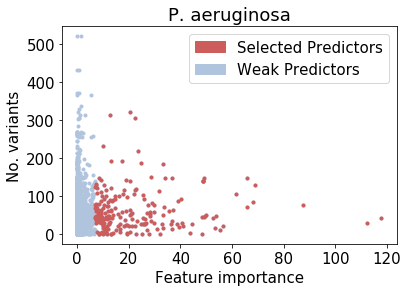

In [ ]:
matplotlib.rcParams.update({'font.size': 15, 'font.weight':'normal'})
plt.plot(list(sorted_features), [allele2variant_count[x] for x in sorted_features.index], '.', color = 'lightsteelblue')

selected_variants = [int(x.split('_')[1]) for x in selected_features_final['Allele ID']]

plt.plot(sorted_features.loc[selected_variants], [allele2variant_count[x] for x in selected_variants], '.', color = 'indianred')

plt.xlabel('Feature importance')
plt.ylabel('No. variants')


handles = [mpatches.Patch(color='indianred', label='Selected Predictors'), mpatches.Patch(color='lightsteelblue', label='Weak Predictors')]
plt.legend(handles=handles, loc=1)
plt.title('P. aeruginosa')

In [ ]:
import sklearn.metrics

In [ ]:
sklearn.metrics.mutual_info_score(list(sorted_features), [allele2variant_count[x] for x in sorted_features.index])

4.920815030353673

In [ ]:
sklearn.metrics.mutual_info_score(sorted_features.loc[selected_variants], [allele2variant_count[x] for x in selected_variants])

4.50315282205584